In [1]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import os
from math import log10, sqrt
import sys

sys.path.insert(0, '..\model')
import models


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (0, 0), fx=1. / 5, fy=1. / 5)
        img = img[0:128, 0:256, :]
        if img is not None:
            images.append(img)
    return images

def estimate_depth(images):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    depth_estimation_model = models.FCDenseNet()
    state = torch.load("path", map_location=device)
    depth_estimation_model.load_state_dict(state['model'])
    depth_images = []

    for img in images:
        downsampled_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        with torch.no_grad():
            depth_estimation_model.eval()
            downsampled_img = Image.fromarray(downsampled_img)
            downsampled_img = transforms.ToTensor()(downsampled_img).unsqueeze_(0)
            downsampled_img = transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5],
                )(downsampled_img)
            predicted_depth_maps_1 = depth_estimation_model(downsampled_img)
            predicted_depth_maps_1 = predicted_depth_maps_1.squeeze(0)
            igg = predicted_depth_maps_1.permute(1,2,0).numpy().reshape(128, 256)
            depth_images.append(igg)
            # print(np.max(igg), np.min(igg))
    return depth_images

def mse_and_psnr(ground_truth, estimated):
    mse_list = []
    psnr_list = []
    for gt, est in zip(ground_truth, estimated):
        i_new = est
        i_new[est < 118] = 118
        i_new[est > 160] = 160
        i_new = (est - 118) * (206 - 0)/(160 - 118)
        gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
        difference_array = np.subtract(gt, i_new)
        squared_array = np.square(difference_array)
        mse = squared_array.mean()
        mse_list.append(mse)
        psnr_list.append(20 * log10(255 / sqrt(mse)))
    print(max(mse_list), min(mse_list), np.std(mse_list), max(psnr_list), min(psnr_list), np.std(psnr_list))
    return sum(mse_list)/len(mse_list), sum(psnr_list)/len(psnr_list)



In [2]:
ground_truth_list = load_images_from_folder("path")
test_images_list = load_images_from_folder("path")
depth_images_list = estimate_depth(test_images_list)

In [8]:
print(len(depth_images_list))

mse = mse_and_psnr(ground_truth_list, depth_images_list)
mse

250
902.40717 87.39557 169.20056 28.715909473845013 18.576778257173064 1.9316736584140084


(422.4088526611328, 22.267816724450988)

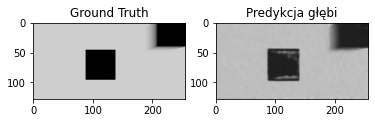

In [3]:
plt.subplot(121)
plt.imshow(ground_truth_list[130], cmap="gray")
plt.title('Ground Truth')

plt.subplot(122)
plt.imshow(depth_images_list[130], cmap="gray")
plt.title('Predykcja głębi')

plt.show()

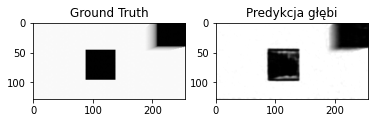

In [4]:
est = depth_images_list[130]
gt = ground_truth_list[130]

i_new = est
i_new[est < 118] = 118
i_new[est > 160] = 160
i_new = (est - 118) * (206 - 0)/(160 - 118)
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)

plt.subplot(121)
plt.imshow(gt, cmap="gray")
plt.title('Ground Truth')

plt.subplot(122)
plt.imshow(i_new, cmap="gray")
plt.title('Predykcja głębi')

plt.show()

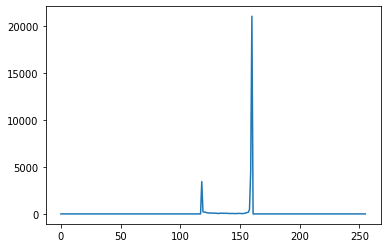

In [5]:
histr1 = cv2.calcHist([est],[0],None,[256],[0,256])

# show the plotting graph of an image
plt.plot(histr1)
plt.show()


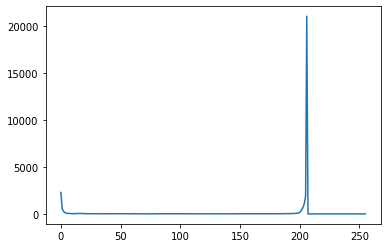

In [6]:
histr = cv2.calcHist([i_new],[0],None,[256],[0,256])

# show the plotting graph of an image
plt.plot(histr)
plt.show()

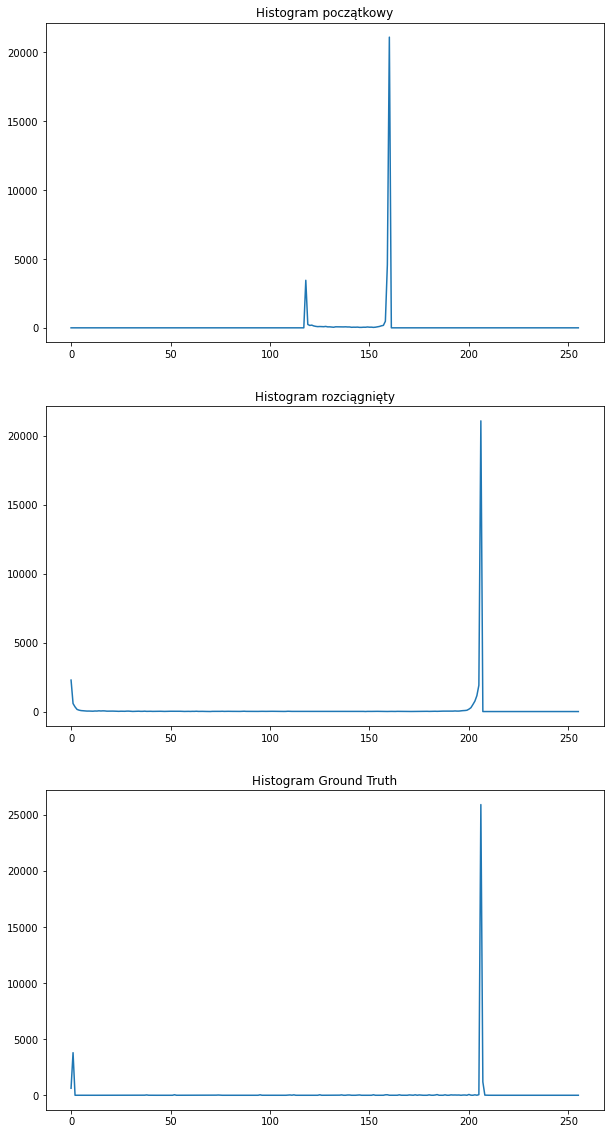

In [7]:
histr_gt = cv2.calcHist([gt],[0],None,[256],[0,256])

# show the plotting graph of an image
plt.figure(figsize=(10,20))

plt.subplot(311)
plt.plot(histr1)
plt.title('Histogram początkowy')

plt.subplot(312)
plt.plot(histr)
plt.title('Histogram rozciągnięty')

plt.subplot(313)
plt.plot(histr_gt)
plt.title('Histogram Ground Truth')

plt.show()